## NetPyNE Tutorial 2: Position- and distance-based connectivity

The following example demonstrates how to spatially separate populations, add inhibitory populations, and implement weights, probabilities of connection, and delays that depend on cell positions or distances.
(more details http://netpyne.org/tutorial.html#tutorial-5-position-and-distance-based-connectivity)

We will build a cortical-like network with six populations (three excitatory and three inhibitory) distributed in three layers: 2/3, 4 and 5. Since we want to distribute the cells spatially, the first thing we need to do is define the volume dimensions where cells will be placed.

## Preliminaries

If you are going to run this notebook locally using Jupyter Notebook, start from following instructions https://github.com/Neurosim-lab/netpyne/blob/development/netpyne/tutorials/README.md.

If you are using Open Source Brain or EBRAINS, everything is already set up.

On any other online platform (e.g. on Google Collab) you might need to run the following commmands to install NEURON and NetPyNE using **pip**:
```
!pip install neuron
!pip install netpyne
```

Now we are ready to start NetPyNE Tutorial.

In [1]:
from netpyne import specs, sim
%matplotlib inline

# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.sizeX = 100              # x-dimension (horizontal length) size in um
netParams.sizeY = 1000             # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 100              # z-dimension (horizontal length) size in um
netParams.propVelocity = 100.0     # propagation velocity (um/ms)
netParams.probLengthConst = 150.0  # length constant for conn probability (um)


--No graphics will be displayed.


Note that we also added two parameters (propVelocity and probLengthConst) which we’ll use later for the connectivity rules.


Next we can define cell properties of each type of cell (E and I), and create our populations labeled according to the cell type and layer e.g. ‘E2’ for excitatory cells in layer 2. We can define the cortical depth range of each population by using the `yRange` parameter. This range can also be specified using normalized values using `ynormRange`. 

In [2]:
## Cell types
secs = {}  # sections dict
secs["soma"] = {"geom": {}, "mechs": {}}  # soma params dict
secs["soma"]["geom"] = {"diam": 15, "L": 14, "Ra": 120.0}  # soma geometry
secs["soma"]["mechs"]["hh"] = {
    "gnabar": 0.13,
    "gkbar": 0.036,
    "gl": 0.003,
    "el": -70,
}  # soma hh mechanism
netParams.cellParams["E"] = {"secs": secs}  # add dict to list of cell params

secs = {}  # sections dict
secs["soma"] = {"geom": {}, "mechs": {}}  # soma params dict
secs["soma"]["geom"] = {"diam": 10.0, "L": 9.0, "Ra": 110.0}  # soma geometry
secs["soma"]["mechs"]["hh"] = {
    "gnabar": 0.11,
    "gkbar": 0.036,
    "gl": 0.003,
    "el": -70,
}  # soma hh mechanism
netParams.cellParams["I"] = {"secs": secs}  # add dict to list of cell params

## Population parameters
netParams.popParams["E2"] = {"cellType": "E", "numCells": 50, "yRange": [100, 300]}
netParams.popParams["I2"] = {"cellType": "I", "numCells": 50, "yRange": [100, 300]}
netParams.popParams["E4"] = {"cellType": "E", "numCells": 50, "yRange": [300, 600]}
netParams.popParams["I4"] = {"cellType": "I", "numCells": 50, "yRange": [300, 600]}
netParams.popParams["E5"] = {"cellType": "E", "numCells": 50, "ynormRange": [0.6, 1.0]}
netParams.popParams["I5"] = {"cellType": "I", "numCells": 50, "ynormRange": [0.6, 1.0]}


## Synaptic mechanism parameters
netParams.synMechParams["exc"] = {
    "mod": "Exp2Syn",
    "tau1": 0.8,
    "tau2": 5.3,
    "e": 0,
}  # NMDA synaptic mechanism
netParams.synMechParams["inh"] = {
    "mod": "Exp2Syn",
    "tau1": 0.6,
    "tau2": 8.5,
    "e": -75,
}  # GABA synaptic mechanism

In terms of stimulation, we’ll add background inputs to all cell in the network. The weight will be fixed to 0.01, but we’ll make the delay come from a gaussian distribution with mean 5 ms and standard deviation 2, and have a minimum value of 1 ms. We can do this using string-based functions: `max(1, normal(5,2)`. 

In [3]:
# Stimulation parameters
netParams.stimSourceParams["bkg"] = {"type": "NetStim", "rate": 20, "noise": 0.3}
netParams.stimTargetParams["bkg->all"] = {
    "source": "bkg",
    "conds": {"cellType": ["E", "I"]},
    "weight": 0.01,
    "delay": "max(1, normal(5,2))",
    "synMech": "exc",
}

# Simulation options
simConfig = (
    specs.SimConfig()
)  # object of class SimConfig to store simulation configuration
simConfig.duration = 1 * 1e3  # Duration of the simulation, in ms
simConfig.dt = 0.025  # Internal integration timestep to use
simConfig.verbose = False  # Show detailed messages
simConfig.recordTraces = {
    "V_soma": {"sec": "soma", "loc": 0.5, "var": "v"}
}  # Dict with traces to record
simConfig.recordStep = 1  # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig.filename = "tut5"  # Set file output name
simConfig.savePickle = False  # Save params, network and sim output to pickle file
simConfig.saveMat = False  # Save params, network and sim output to pickle file


simConfig.analysis["plotRaster"] = {
    "orderBy": "y",
    "orderInverse": True,
    "saveFig": True,
}  # Plot a raster
simConfig.analysis["plotTraces"] = {
    "include": [("E2", 0), ("E4", 0), ("E5", 5)],
    "saveFig": True,
    "oneFigPer": "trace",
}  # Plot recorded traces for this list of cells
simConfig.analysis["plot2Dnet"] = {
    "saveFig": True
}  # plot 2D cell positions and connections
simConfig.analysis["plotConn"] = {"saveFig": True}  # plot connectivity matrix
# simConfig.analysis['plot2Dfiring'] = {'saveFig': True, 'showFig': True}

If we run the model at this point we will see the cells are distributed into three layers as specified, and they all spike randomly with an average rate of 20 Hz driven by background input:


Start time:  2024-10-30 15:07:14.028197




Creating network of 6 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 300 
  Done; cell creation time = 0.04 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 300 
  Done; cell stims creation time = 0.03 s.
Recording 3 traces of 1 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 2.22 s; real-time ratio: 0.45.

Gathering data...


  Done; gather time = 0.03 s.

Analyzing...
  Cells: 300
  Connections: 300 (1.00 per cell)
  Spikes: 6075 (20.25 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 2.22 s
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... trace


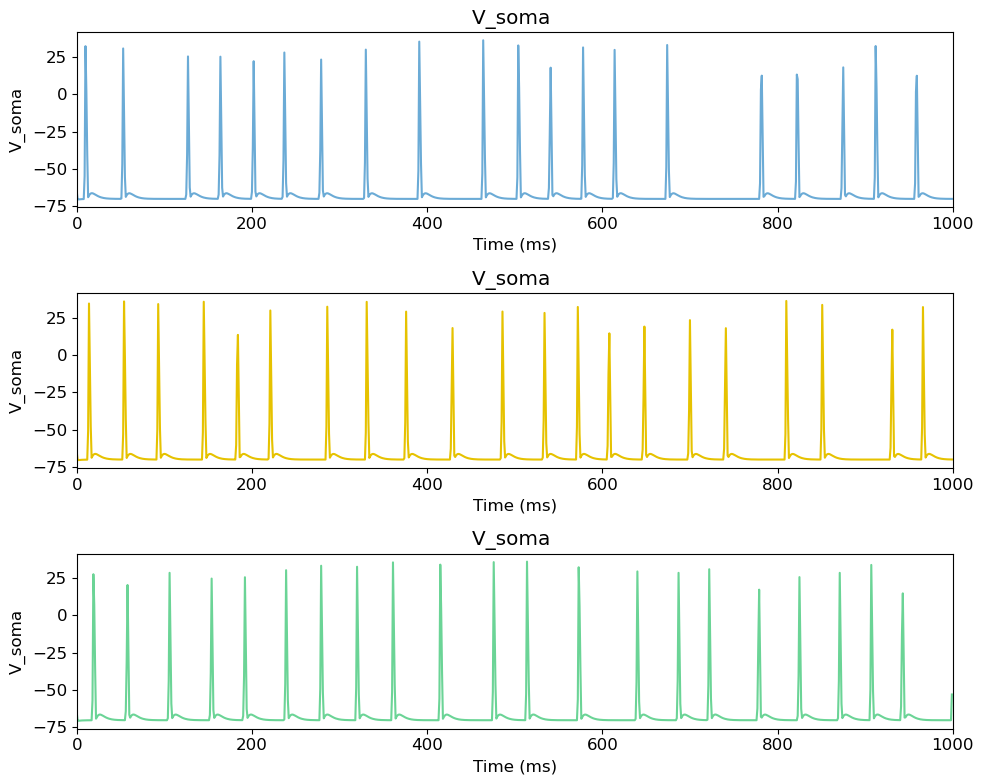

Plotting 2D representation of network cell locations and connections...


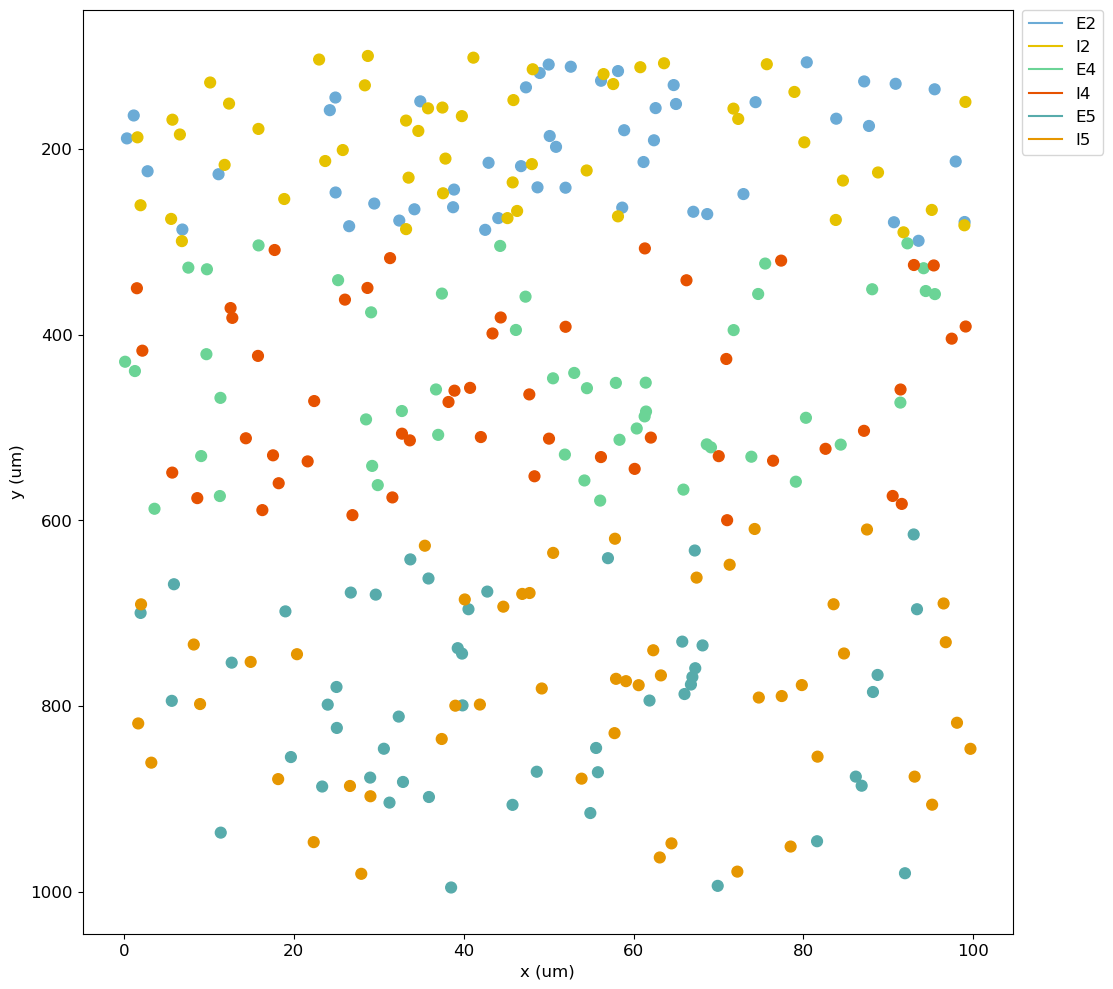

Plotting connectivity matrix...


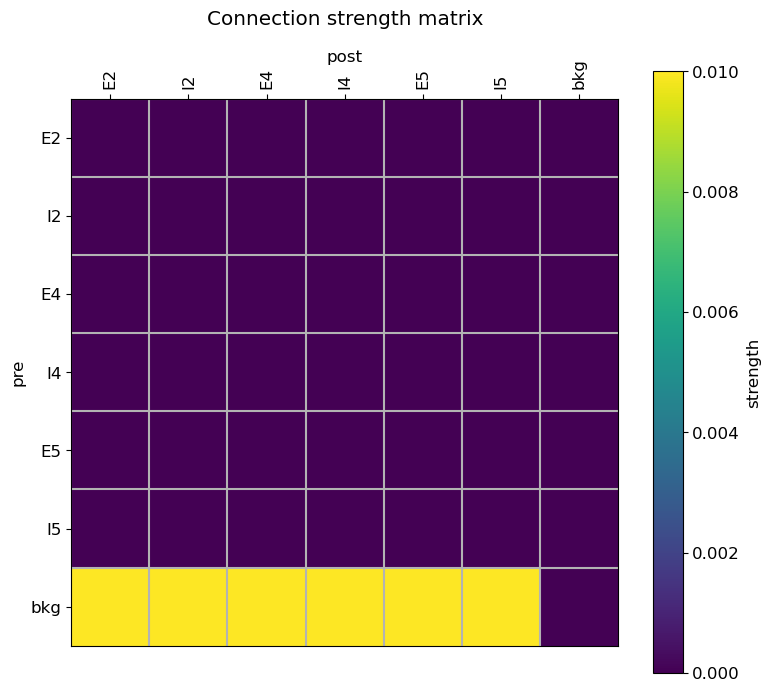

  Done; plotting time = 1.58 s

Total time = 3.90 s


In [4]:
# Create network and run simulation
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

Let’s now add excitatory connections with some spatially-dependent properties to illustrate NetPyNE’s capabilities.

Running the model now shows excitatory connections in red, and how cells in the deeper layers (higher y values) exhibit lower rates and higher synchronization, due to increased weights leading to depolarization blockade. This difference is also visible in the voltage traces of layer 2 vs layer 5 cells:


Start time:  2024-10-30 15:07:17.942111




Creating network of 6 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 300 
  Done; cell creation time = 0.03 s.
Making connections...


  E->all: 100%|##########| Creating synaptic connections for 300/300 postsynaptic cells on node 0 (probabilistic connectivity)


  Number of connections on node 0: 4539 
  Done; cell connection time = 0.56 s.
Adding stims...
  Number of stims on node 0: 300 
  Done; cell stims creation time = 0.03 s.
Recording 3 traces of 1 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 7.34 s; real-time ratio: 0.14.

Gathering data...
  Done; gather time = 0.13 s.

Analyzing...
  Cells: 300
  Connections: 4839 (16.13 per cell)
  Spikes: 5120 (17.07 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 7.34 s
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... trace


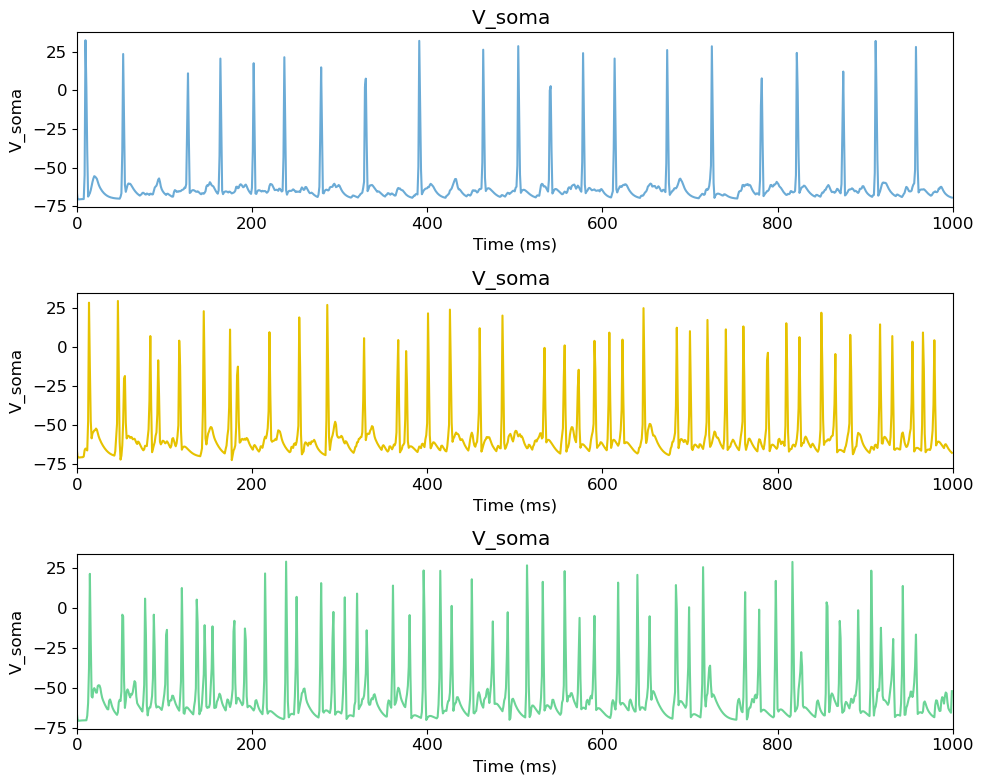

Plotting 2D representation of network cell locations and connections...


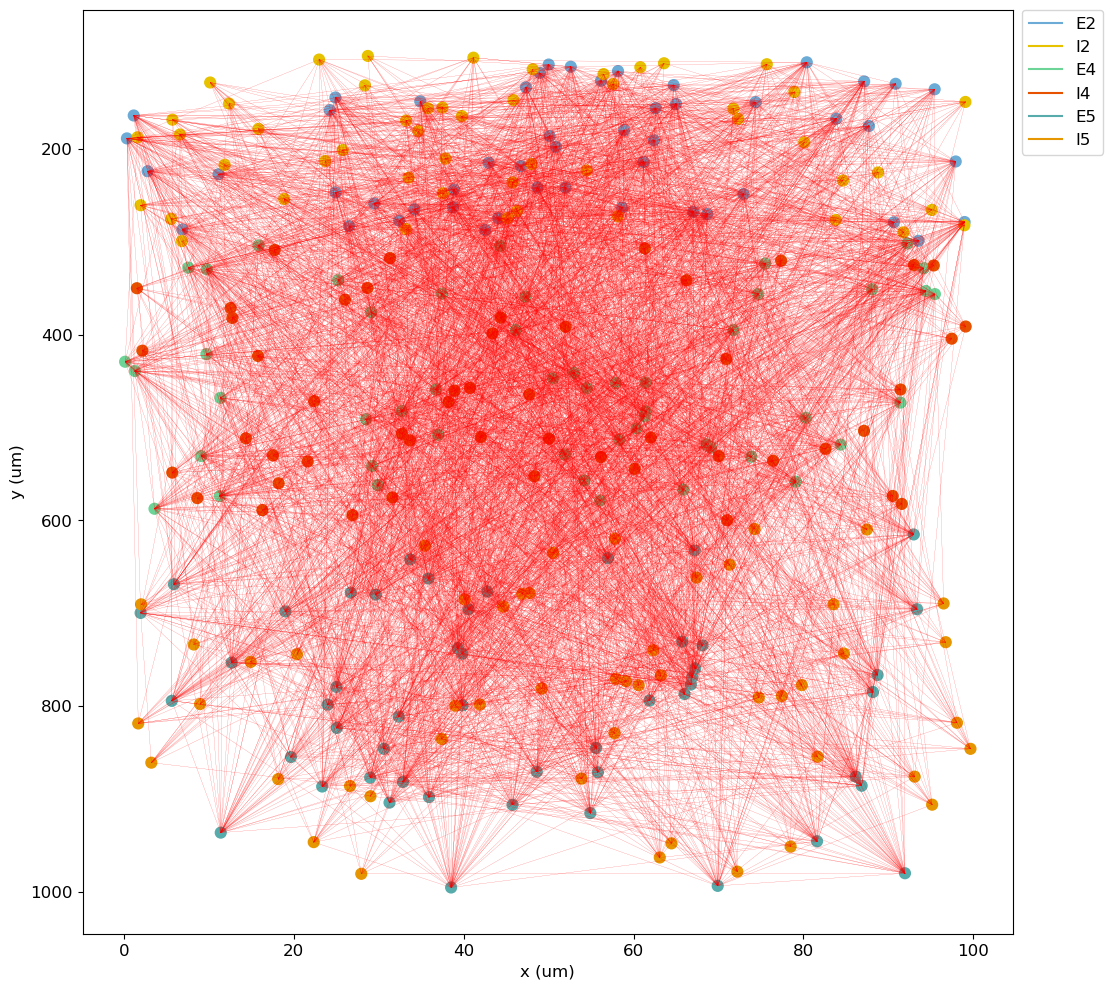

Plotting connectivity matrix...


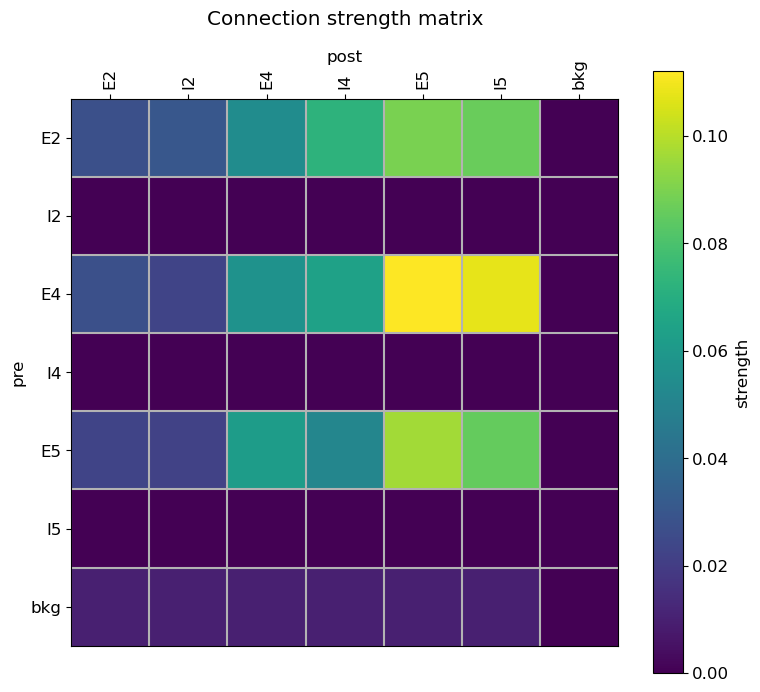

  Done; plotting time = 5.03 s

Total time = 13.12 s


In [5]:
## Cell connectivity rules
netParams.connParams["E->all"] = {
    "preConds": {"cellType": "E"},
    "postConds": {"y": [100, 1000]},  #  E -> all (100-1000 um)
    "probability": 0.1,  # probability of connection
    "weight": "0.005*post_ynorm",  # synaptic weight
    "delay": "dist_3D/propVelocity",  # transmission delay (ms)
    "synMech": "exc",
}  # synaptic mechanism

# Create network and run simulation
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

Finally, we add inhibitory connections which will project only onto excitatory cells, specified here using the pop attribute.

Notice that the 2D network diagram now shows inhibitory connections in blue, and these are mostly local/lateral within layers, due to the distance-related probability restriction. These local inhibitory connections reduce the overall synchrony, introducing some richness into the temporal firing patterns of the network.


Start time:  2024-10-30 15:07:31.073368




Creating network of 6 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 300 
  Done; cell creation time = 0.05 s.
Making connections...


  E->all: 100%|##########| Creating synaptic connections for 300/300 postsynaptic cells on node 0 (probabilistic connectivity)
  I->E: 100%|##########| Creating synaptic connections for 150/150 postsynaptic cells on node 0 (probabilistic connectivity)


  Number of connections on node 0: 6796 
  Done; cell connection time = 0.90 s.
Adding stims...
  Number of stims on node 0: 300 
  Done; cell stims creation time = 0.03 s.
Recording 3 traces of 1 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 11.27 s; real-time ratio: 0.09.

Gathering data...
  Done; gather time = 0.18 s.

Analyzing...
  Cells: 300
  Connections: 7096 (23.65 per cell)
  Spikes: 4902 (16.34 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 11.27 s
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... trace


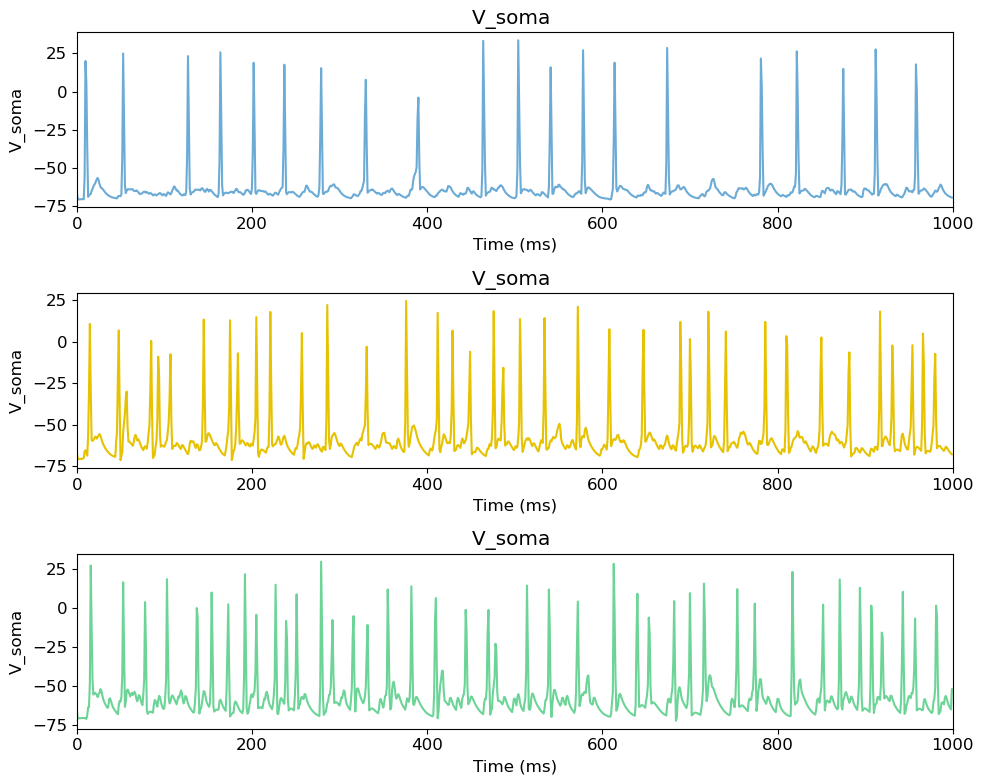

Plotting 2D representation of network cell locations and connections...


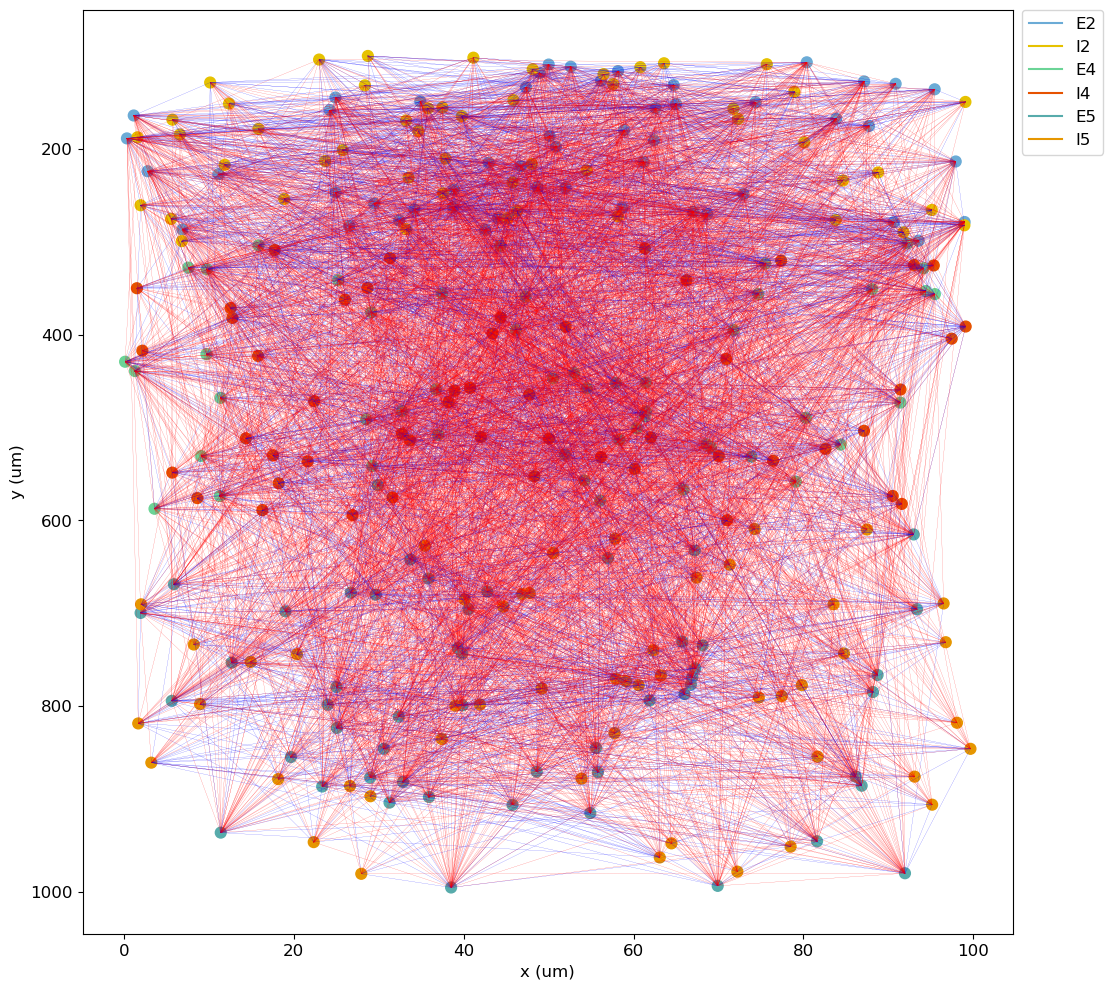

Plotting connectivity matrix...


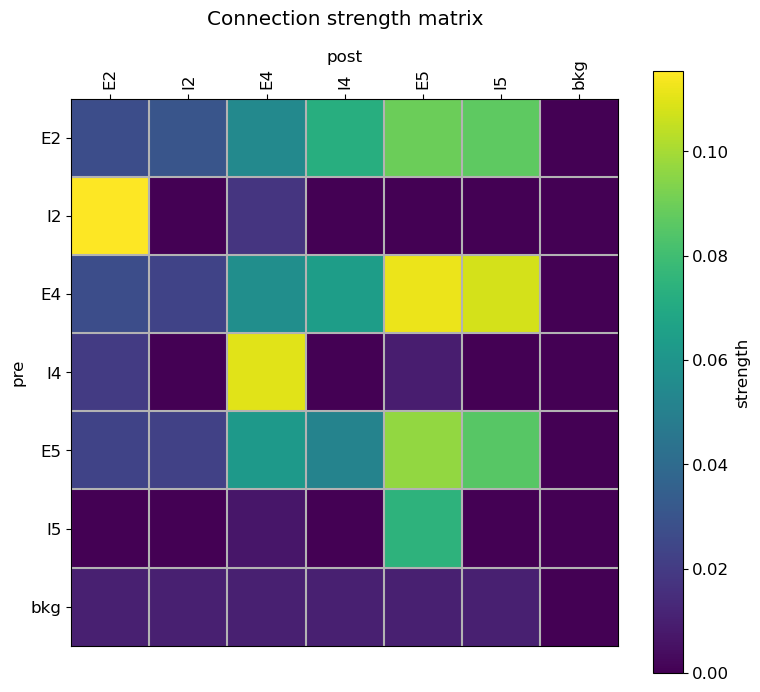

  Done; plotting time = 6.55 s

Total time = 18.99 s


In [6]:
netParams.connParams["I->E"] = {
    "preConds": {"cellType": "I"},
    "postConds": {"pop": ["E2", "E4", "E5"]},  #  I -> E
    "probability": "0.4*exp(-dist_3D/probLengthConst)",  # probability of connection
    "weight": 0.001,  # synaptic weight
    "delay": "dist_3D/propVelocity",  # transmission delay (ms)
    "synMech": "inh",
}  # synaptic mechanism

# Create network and run simulation
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)